In [15]:
# Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [22]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [25]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
dates = session.query(Measurement.date).all()
dates.sort(reverse=True)
mrd = dates[0][0] # mrd = most recent date
print(str(mrd))
mrd = mrd.split("-")

2017-08-23


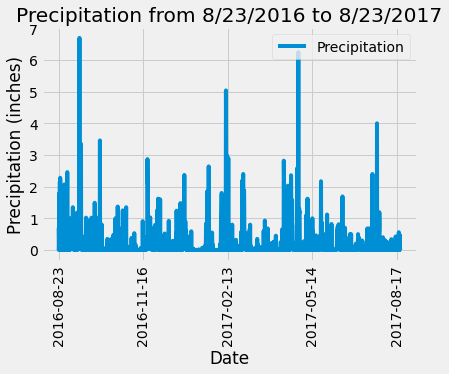

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(int(mrd[0]),int(mrd[1]),int(mrd[2]))-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,
      Measurement.prcp]
last_precip = session.query(*sel).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(last_precip, columns=['Date','Precipitation'])
precip_df.set_index('Date',inplace=True)
precip_df.dropna(inplace=True)


# Sort the dataframe by date
precip_df.sort_values(by='Date',inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot.line()
plt.title('Precipitation from 8/23/2016 to 8/23/2017')
plt.ylabel('Precipitation (inches)')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.show()



In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_summary = precip_df.describe()
precip_summary

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number stations in the dataset
station_ids = session.query(Station.id).all()
num_stations = len(station_ids)
print("There are " + str(num_stations) + " stations in the dataset.")

There are 9 stations in the dataset.


In [30]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
m_stations = session.query(Measurement.station).all()
sta = []
for x in range(len(m_stations)):
    sta.append(m_stations[x][0])
active_stations = pd.Series(sta).value_counts()
df = pd.DataFrame(active_stations,columns=['Frequency'])
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'index':'Station'},inplace=True)
most_active_station = df.loc[df['Frequency']==df['Frequency'].max()]['Station'][0]
print(df)
print("")
print(f"Most active station: {most_active_station}")

       Station  Frequency
0  USC00519281       2772
1  USC00519397       2724
2  USC00513117       2709
3  USC00519523       2669
4  USC00516128       2612
5  USC00514830       2202
6  USC00511918       1979
7  USC00517948       1372
8  USC00518838        511

Most active station: USC00519281


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
temp_info = session.query(*sel).\
    filter(Measurement.station==most_active_station)
print(f"For most active station ({most_active_station}):")
print("")
print(f"Lowest Temperature (F): {temp_info[0][0]}")
print(f"Highest Temperature (F): {temp_info[0][1]}")
print(f"Average Temperature (F): {round(temp_info[0][2],1)}")

For most active station (USC00519281):

Lowest Temperature (F): 54.0
Highest Temperature (F): 85.0
Average Temperature (F): 71.7


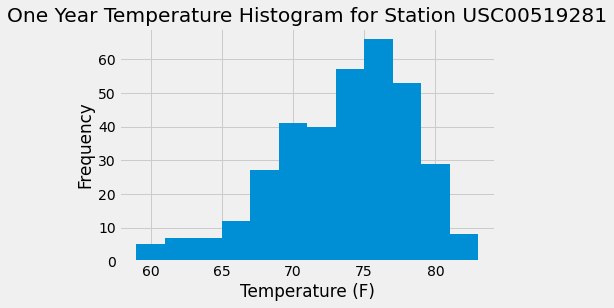

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.tobs]

temp_year = session.query(*sel).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station=='USC00519281')

temps = []
for x in range(len(temp_year.all())):
    temps.append(temp_year.all()[x][0])

temperatures = pd.Series(temps);
temperatures.plot.hist(bins=12);
plt.title("One Year Temperature Histogram for Station USC00519281");
plt.xlabel("Temperature (F)");

# Close session

In [33]:
# Close Session
session.close()